## Installing Required Python Packages

Note: run the following cell once. 

In [44]:
# !pip install -r requirements.txt

## Importing essential Python Packages

In [19]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
from scipy.optimize import minimize
from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook
# %matplotlib inline
# %matplotlib widget
# %matplotlib ipympl

`sbfTools` hold all the auxiliary functions we use in this notebook.
Make sure that `sbfTools.py` is in located in the same folder as this notebook.

In [20]:
# make sure 
from sbfTools import *

## `get_RMS` 

Defining the `rms` of the flux deviations from the `r^1/4` profile, extrapolated in the outer regions of the target galaxy

In [21]:
def get_RMS(obj, r0, r1, nr, sky_factor, options=""):
    '''
    
    Returns:
        - rms: the rms of deviations
        - n_cross: number of ellipses crossing each other
    
    '''
    
    sky = int(sky_factor*obj.sky_med)
    n_cross = 0
    
    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=1, 
                    model_mask=0, model=1000, options=options) != 'OK':
        n_cross+=1
        
    model = 1000 
    n_cross += Xellipses(obj.list_ellipses(model=1000))
    root = obj.objRoot
    suffix = '.%03d'%model

    ellipseFile = root+'/elliprof'+suffix
    df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
    df = df.apply(pd.to_numeric, errors='coerce')
    x = df.Rmaj**0.25
    y = 2.5*np.log10(df.I0)

    maxX = np.max(x)
    minX = np.min(x)
    dx = maxX-minX
    x1 = 0.70*dx+minX
    x2 = maxX-0.10*dx
    x3 = maxX-0.10*dx
    x0 = x[((x<x2) & (x>x1))]
    y0 = y[((x<x2) & (x>x1))]

    m, b = np.polyfit(x0, y0, 1)

    x_data = x[((x>=x3))]
    y_data = y[((x>=x3))]
    y_model = m*x_data+b

    rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
    return rms, n_cross


def get_f(obj, r0, r1, nr, options=""):
    '''
    
    
    Returns:
        - func: a function that gets the sky_factor and returns the rms of deviations
        This function in its heart uses function `get_RMS` 
    
    '''
    
    def func(sky_factor):

        rms, n_cross = get_RMS(obj, r0, r1, nr, sky_factor, options=options)

        sig = rms 

        if sig>10 or np.isnan(sig) or n_cross>0:
            sig = 10

        return -sig
    
    return func

In [22]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [23]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
# inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/'


configFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/config/'

In [24]:
# obj = ellOBJ("n0679", inFolder=inFolder, config=configFolder)
# obj = ellOBJ("u12517")
# obj = ellOBJ("n0439")

# obj = ellOBJ("ic4926", inFolder=inFolder, config=configFolder)


# obj = ellOBJ("u03396", inFolder=inFolder, config=configFolder)


# challenging
obj = ellOBJ("ic4798", inFolder=inFolder, config=configFolder)



# obj = ellOBJ("n3308", inFolder=inFolder)

# obj = ellOBJ("n7265", inFolder=inFolder)

# obj = ellOBJ("n7426", inFolder=inFolder)

## very bright nearby object
# obj = ellOBJ("n6577", inFolder=inFolder)

# obj = ellOBJ("ic4727", inFolder=inFolder)

# obj = ellOBJ("ic0380", inFolder=inFolder)

## arms, shells
# obj = ellOBJ("n2418", inFolder=inFolder)

## doesn't exist
# obj = ellOBJ("e137008", inFolder=inFolder)

# obj = ellOBJ("u11990", inFolder=inFolder)

# bright nearby object
# obj = ellOBJ("n3268", inFolder=inFolder, config=configFolder)

# obj = ellOBJ("n7274", inFolder=inFolder)

### Spiral arms, reject
# obj = ellOBJ("n6688", inFolder=inFolder)

## nuclear dust + companion
# obj = ellOBJ("n4825", inFolder=inFolder)

# obj = ellOBJ("n6768", inFolder=inFolder)

# obj = ellOBJ("n6223", inFolder=inFolder)

In [25]:
obj.sky_med, obj.x0, obj.y0

(3412.7802734375, 560.801, 560.391)

In [26]:
obj.x_max, obj.y_max

(1022, 1025)

<IPython.core.display.Javascript object>


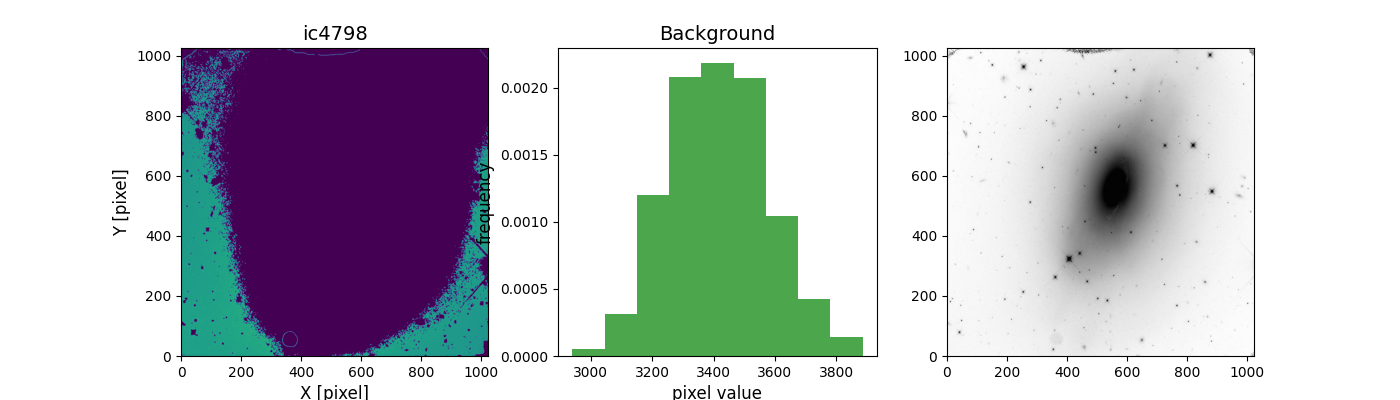

Back Median: 3412.78
Back Mean: 3417.57
Back Stdev: 157.55
fig. name:  Outputs_ic4798//ic4798_initial_back.png


In [27]:
obj.backSextract(thresh=0.03)
ax1, ax2, ax3 = obj.plot_background()

pngName = obj.objRoot+'/'+obj.name+'_initial_back.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

<IPython.core.display.Javascript object>


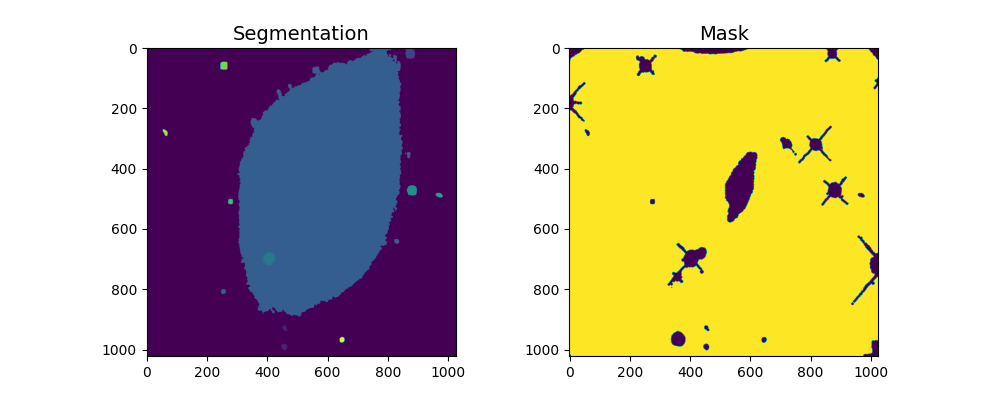

fig. name:  Outputs_ic4798//ic4798_initial_mask.png


In [28]:
ax1, ax2 = obj.naive_Sextract(minArea=200, thresh=3, mask=0, smooth=5)
ax1.set_title("Segmentation", fontsize=14)

obj.addMasks(maskList=[0], mask=1)

## improting Dmask and add it to the initial mask we find using 
## a crude SExtractor run
Dmask =  obj.inFolder+'{}/{}j.dmask'.format(obj.name, obj.name)
if os.path.exists(Dmask):
    obj.inputMaks(Dmask, mask=0)
    obj.addMasks(maskList=[0,1], mask=1)
else:
    print(Dmask+" doesn't exist.")

im, h = obj.maskOpen(mask=1)
ax2.imshow(np.flipud(im))
ax2.set_title("Mask", fontsize=14)

pngName = obj.objRoot+'/'+obj.name+'_initial_mask.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

## Running Elliprof

Here, we run `elliprof` for the firt time. The initial mask that was generated above (e.g. mask=1) is utilized here and `model=0` is created. Usually, the Kron_radius factor is set to a value greater than 2 and smaller than 4.
The main goal is to generate very crude model.

- `r0`: Inner radius to fit
- `r1`: Outer radius to fit, i.e. `obj.outerR(c_kron)`, where `outerR` takes the Kron radius factor and converts it to number of pixels
- `c_kron`: Kron radius factor
- `sky`: sky value, which is roughly about 90% of the median of the values of the background pixels. *Note:* The sky level would be fine tuned later.
- `k`: A factor to determine the number of fitting radii, i.e. `nr=r1/k`
- `options`: Any other that `elliprof` accepts. 

<IPython.core.display.Javascript object>


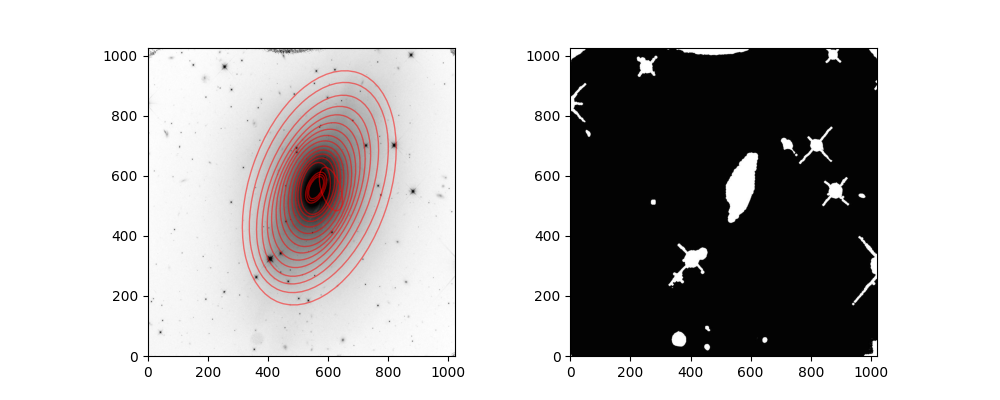

===== MONSTA =====
   1
   2        string name 'ic4798'
   3        rd 1 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262//ic4798/ic4798j.fits'
   4        sc 1 3071                            ! sky subtraction
   5        rd 2 Outputs_ic4798//mask.001
   6        mi 1 2
   7        tv 1 sqrt JPEG=Outputs_ic4798//ic4798.000.jpg
   8
   9        
  10        cop 3 1 
  11        elliprof 3  model rmstar x0=560.801 y0=560.391 r0=7 r1=404 nr=27 niter=10  
  12        print elliprof file=Outputs_ic4798//elliprof.000
  13        cop 4 1                               ! object
  14        si 4 3                                ! object - model
  15        ac 3 3071                  
  16        !mi 3 2 
  17        mi 4 2                                ! multiply by mask
  18        wd 3 Outputs_ic4798//model.000
  19        wd 4 Outputs_ic4798//resid.000
  20        tv 4 JPEG=Outputs_ic4798//resid.000.jpg
  21        tv 3 JPEG=Outputs_ic4798//model.000.jpg
  22        q
  23        

N_cross: 8
r0: 7
r1: 404
nr: 27
sky: 3071
fig. name:  Outputs_ic4798//ic4798_basic_model.png
CPU times: user 1.07 s, sys: 339 ms, total: 1.41 s
Wall time: 1.23 s


In [29]:
%%time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))


r0 = 7              # pixel
c_kron = 3     # Kron radius factor
k = 15 
sky_factor = 0.9    # always less than one

r1 = obj.outerR(c_kron)
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

## input mask. Usually mask = 1 or any value chosen for the initial mask from the previous cell
## since we have not specify the model number, the generated model takes a value of `0`
msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="", mask=1)

## Calculating the number of crossing ellipses, the generated model = 0, from previous linen_cross = Xellipses(obj.list_ellipses(model=0))
obj.tv(options="log", ax=ax1)
obj.plot_ellipse(model=0, ax=ax1, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

n_cross = Xellipses(obj.list_ellipses(model=0))

print("N_cross: %d"%n_cross)   # No. of crossing ellipses
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

obj.tv_mask(mask=1, ax=ax2)

pngName = obj.objRoot+'/'+obj.name+'_basic_model.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

## Second round of elliprof

Here, we use the primary model that we generated in the previous cell to cover the masked regions.
Then we run SExtractor for additional mask. The residuals of model=0 is used to create another mask. The initial mask can be further augmented with the mask we generate here.

- `model=0`: initial profile model from the previous cell. The masked regions are replaced by this model
- `model_mask`: the model that is used to patch the masked regions

**Top**
- Left: Red ellipse displays the galaxy border defined by Kron radius

In [30]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# text = widgets.Text(
#        value='My Text',
#        description='Title', )

# calendar = widgets.DatePicker(
#            description='Select Date')

slider_inner = widgets.FloatSlider(value=9, min=3, max=15, step=1, description='r0 (pixels)')
slider_kron = widgets.FloatSlider(value=2.5, min=1, max=5, step=0.25, description='Kron_factor')
slider_sky = widgets.FloatSlider(value=0.90, min=0.1, max=1.2, step=0.05, description='sky_factor')
slider_nEll = widgets.FloatSlider(value=15, min=5, max=50, step=1, description='k')

elliprof_options = widgets.Dropdown(
       options=['COS3X=0', 'COS3X=1', 'COS3X=2', 'COS4X=1', 'COS4X=2', 'COS3X=-1', 'COS3X=-2'],
       value='COS3X=0',
       description='Mode:')

# checkbox = widgets.Checkbox(
#            description='Check to invert',)
checkbox = widgets.Checkbox(description='Combine Mask', value = False)

box1 = widgets.VBox([slider_inner, slider_kron, slider_sky, slider_nEll])
box2 = widgets.VBox([elliprof_options])

widgets.HBox([box1, box2])





<IPython.core.display.Javascript object>


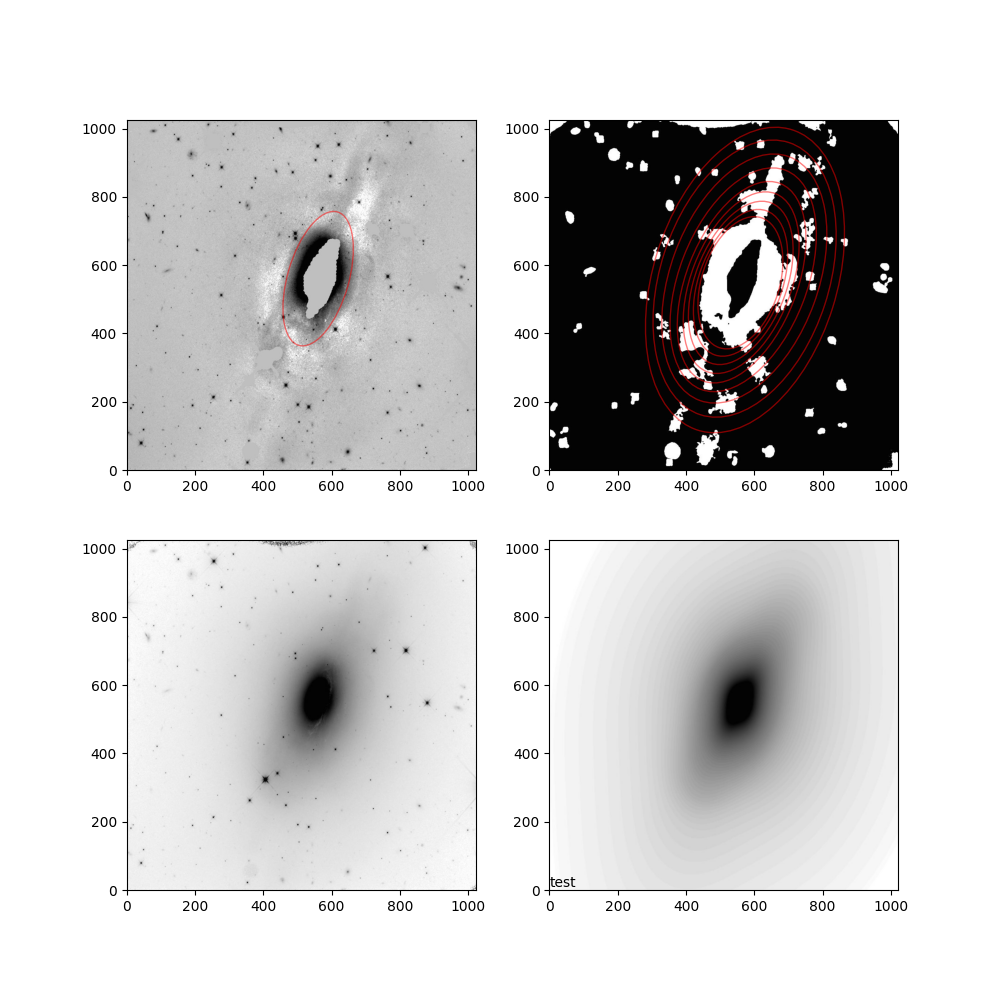

fig. name:  Outputs_ic4798//ic4798_initial_model.png


7

In [36]:
r0 = 200 # slider_inner.value          # pixels
c_kron = slider_kron.value # *kron_radius
r1 = obj.outerR(c_kron)    # pixels
k = slider_nEll.value
nr = int(np.round((r1-r0)/k))
sky_factor = slider_sky.value    # always less than one


## keep changing r0 until you won't get error messages from elliprof
   
options = elliprof_options.value
# options = ''
    
## using mask=1  --> primary mask
## generate model = 0   
## uses model_mask for the masked regions
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med*sky_factor, niter=50, mask=1, model_mask=0, options=options)

# using residuals of model 0 --> mask 2
obj.objSExtract(model=0, smooth=5, minArea=300, thresh=3, mask=2, renuc=1) 

# plotting model 0
fig, ax = plt.subplots(2, 2, figsize=(10,10))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
Ell = ((obj.x0, obj.y0), 1.*obj.a, 1.*obj.b, obj.angle)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')
ax[0][0].add_patch(e)

obj.tv_mask(mask=2, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')




obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')


pngName = obj.objRoot+'/'+obj.name+'_initial_model.png'
plt.savefig(pngName)
print("fig. name: ", pngName)


resid = True

text=ax[1][1].text(0,0, "test", va="bottom", ha="left") 
def onclick(event):
        global resid
        tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        text.set_text(tx)
        if event.inaxes == ax[0,1]:
            event.inaxes.set_title("Mask 2 (additional)")
            root = obj.objRoot
            segment = root+'/objCheck.000.segment'
            objName = root+'/objCheck.000'
            maskName = root+'/mask.002'
            
            imarray, header = imOpen(segment)
            i = int(event.xdata)
            j = int(event.ydata)
            
            n = imarray[j,i]
            text.set_text(str(i)+' '+str(j)+' '+str(n))
            imarray[(imarray==n)] = 0 
            fits.writeto(segment, np.float32(imarray), header, overwrite=True)
            seg2mask(segment, objName)
            ## Monsta script
            script = """
            rd 1 """+objName+"""
            rd 5 './common.mask'
            mi 1 5
            wd 1 """+maskName+""" bitmap
            tv 1 JPEG="""+maskName+""".jpg
            q

            """       
            obj.run_monsta(script, root+'monsta.pro', root+'monsta.log')
#             obj.tv_model(model=0, ax=ax[0,1], options='sqrt')
            obj.tv_mask(mask=2, ax = ax[0][1])
            draw()
            
        if event.inaxes == ax[0,0]:
            event.inaxes.set_title(resid)
            if resid:
                obj.tv(ax = ax[0][0], options='sqrt')
                resid = False
            else:
                obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
                resid = True
            draw()
            

fig.canvas.callbacks.connect('button_press_event', onclick)


In [15]:
checkbox

Checkbox(value=False, description='Combine Mask')

In [19]:
checkbox.value

True

## Mask augmentation

If we are happy with the additional mask we found above, we add these two masks and update the primary mask.
After updating the mask (`mask=1`), the previous cell can be iteratively executed with updating the mask multiple time until we are satisfied.

In [60]:
# combining mask1 and mask2 ----> mask1
if checkbox.value==True:
    obj.addMasks(maskList=[1,2], mask=1)

<IPython.core.display.Javascript object>


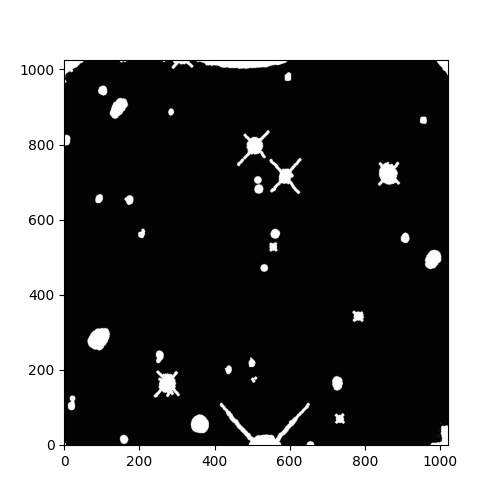

In [14]:
plt.figure(figsize=(5,5))
plt.subplot(111)
ax = plt.gca()
obj.tv_mask(mask=1, ax=ax)

## Updating the background level

Here, we update the background factor, and regenerate the `elliprof` model until the median of the residual value of the background pixels is roughly zero. 

In [63]:
def optimize_skt_factor(obj, sky_factor, r0, r1, nr, options="", 
                        mask=1, model_mask=0, n_repeat=25, model=0, verbose=False):
    
    First = True

    for i in range(n_repeat):

        sky = sky_factor*obj.sky_med

        if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=mask, model_mask=model_mask, model=model) != 'OK':
            return 0

        resid_name = obj.objRoot+"resid"+'.%03d'%model
        back_mask = obj.objRoot+"back_mask.fits"

        imarray, header = imOpen(resid_name)
        mskarray, header = imOpen(back_mask)

        masked_image = imarray*mskarray


        a = masked_image
        a = a[(a!=0)]
        std = np.std(a)
        mean = np.mean(a)

        a = a[((a>mean-3.*std)&(a<mean+3.*std))]

        median = np.median(a)
        mean = np.mean(a)
        std = np.std(a)

        sky_factor = median/obj.sky_med + sky_factor

        abs_median = np.abs(median)
        if First:
            min_absmed = abs_median
            min_factor = sky_factor
            min_med = median 
            First = False
        elif abs_median<min_absmed:
            min_absmed = abs_median
            min_factor = sky_factor
            min_med = median       


        if i%5==0 and verbose:
            print("%02d median:%.2f factor:%.4f"%(i, median, sky_factor))

    if verbose:
        print("Optimum --- median:%.2f factor:%.4f"%(min_med, min_factor))
    
    
    ## Finally generate a model for the optimum sky_factor
    obj.elliprof(r0, r1, nr=nr, sky=min_factor*obj.sky_med, niter=10, mask=mask, 
                 model_mask=model_mask, model=model)
    
    return min_factor



optimize_skt_factor(obj, sky_factor, r0, r1, nr, options=options, model=999)   # model #: the elliprof model id


0.9628219698700865

In [68]:
i = 1

while i<=10:
    
    r0 = np.random.randint(8,15)
    r1 = np.random.randint(obj.outerR(c_kron*0.9) , obj.outerR(c_kron*2))
    k = np.random.randint(8,15)
    nr = int(np.round(r1/k))
    sf = np.random.uniform(0.75,0.95)
    
    if i==1:
        model_mask=0
    else:
        model_mask = 1000-i+1
        
    sky_factor = optimize_skt_factor(obj, sf, r0, r1, nr, options=options, model_mask=model_mask,
                                     model=1000-i, verbose=False)
    
    
    if sky_factor!=0:
        
        ## how many ellipses cross each other
        n_cross = Xellipses(obj.list_ellipses(model=1000-i))
    
        if n_cross<4:
            print(sf, r0, r1, nr, n_cross)
            print(i, '%.3f'%sky_factor)
            i+=1
        
        


0.8375715580502748 14 321 27 1
1 0.926
0.8905165562435288 14 422 47 3
2 0.877
0.8405399658823183 14 413 32 1
3 0.916
===== MONSTA =====
   1
   2        string name 'u03396'
   3        rd 1 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262//u03396/u03396j.fits'
   4        sc 1 2086.8397475388483                            ! sky subtraction
   5        rd 2 Outputs_u03396//mask.001
   6        mi 1 2
   7        tv 1 sqrt JPEG=Outputs_u03396//u03396.996.jpg
   8
   9        
  10        cop 6 2
  11        mc 6 0
  12        ac 6 1
  13        si 6 2
  14        rd 7 Outputs_u03396//model.997
  15        sc 7 2086.8397475388483   ! aky subtraction
  16        mi 7 6
  17        cop 3 1 
  18        ai 3 7 
  19        elliprof 3  model rmstar x0=563.268 y0=563.234 r0=12 r1=437 nr=49 niter=10  
  20        print elliprof file=Outputs_u03396//elliprof.996
  21        cop 4 1                               ! object
  22        si 4 3                                ! object - model

0.9160482408385202 13 268 27 2
4 0.951
0.9485189394351329 14 247 19 3
5 0.962
0.8258424388374068 13 267 22 2
6 0.954
0.7507643130570727 14 259 18 3
7 0.953


TopologyException: found non-noded intersection between LINESTRING (538.287 567.772, 538.293 567.772) and LINESTRING (538.299 567.772, 538.293 567.772) at 538.29313242273474 567.77198865574269


((548.56, 568.24, 14.0, 0.0, 182.61), (562.78, 562.52, 16.9, 15.6832, 201.39))


TopologyException: found non-noded intersection between LINESTRING (534.575 567.602, 534.575 567.602) and LINESTRING (534.575 567.602, 534.575 567.602) at 534.57452583925465 567.60247735613734


((548.56, 568.24, 14.0, 0.0, 182.61), (562.78, 562.55, 20.2, 18.685, 201.11))


TopologyException: found non-noded intersection between LINESTRING (536.016 567.668, 536.02 567.668) and LINESTRING (536.024 567.669, 536.02 567.668) at 536.02004747328886 567.66837092279786


((548.56, 568.24, 14.0, 0.0, 182.61), (562.83, 562.56, 24.0, 22.248, 201.85))


TopologyException: found non-noded intersection between LINESTRING (534.869 567.616, 534.87 567.616) and LINESTRING (534.872 567.616, 534.87 567.616) at 534.87047218665487 567.61596796043636


((548.56, 568.24, 14.0, 0.0, 182.61), (562.87, 562.58, 28.2, 26.4234, 203.70999999999998))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.83, 562.51, 33.0, 31.250999999999998, 205.64))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.76, 562.5, 38.5, 36.96, 213.39))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.85, 562.46, 44.5, 42.72, 215.1))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.82, 562.43, 51.2, 48.9472, 213.66))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.81, 562.41, 58.7, 56.117200000000004, 209.12))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.81, 562.42, 67.0, 63.315, 206.25))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.77, 562.42, 76.1, 71.0013, 203.4))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.84, 562.35, 86.1, 79.4703, 201.01999999999998))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.82, 562.41, 97.0, 87.979, 199.88))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (563.02, 562.32, 109.0, 97.991, 198.04000000000002))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (563.07, 562.55, 122.1, 109.7679, 199.04000000000002))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.81, 562.25, 136.3, 123.62410000000001, 199.92000000000002))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.87, 561.72, 151.6, 139.1688, 200.63))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.64, 561.98, 168.3, 154.836, 202.70999999999998))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.49, 562.44, 186.3, 173.44530000000003, 205.17000000000002))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.66, 561.7, 205.7, 192.7409, 207.64))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (562.41, 562.03, 226.6, 212.7774, 212.48000000000002))


TopologyException: found non-noded intersection between LINESTRING (548.551 568.24, 548.56 568.24) and LINESTRING (548.569 568.24, 548.56 568.24) at 548.55999999999995 568.24000000000001


((548.56, 568.24, 14.0, 0.0, 182.61), (561.43, 561.51, 249.0, 234.30900000000003, 215.49))
0.7644988499434795 14 437 40 3
8 0.910
0.8002038524580813 10 373 27 3
9 0.894
0.7828432782263877 13 334 28 3
10 0.899


## An alternative to tune the background level

Here, we fit an `r^1/4` profile, and optimize the background factor to minimize the `rms` of deviations from the profile in the outer regions.

This method doesn't necessarily work for all galaxies. There are smaller galaxies that do not obey the `r^1/4` law. For such instances, the other method might be quite adequate.

A Bayesian optimization technique is leveraged to find the optimum sky factor here. The boundaries of the search space is set to be `(0.65, 1.05)`, however this can be altered as required.


In [71]:
r0, r1, nr

(13, 334, 28)

In [ ]:
%%time

## make it `True` if you ever want to use this routine

ll = []
if True:
    from bayes_opt import BayesianOptimization
    ### https://github.com/fmfn/BayesianOptimization

    # Bounded region of parameter space
    pbounds = {'sky_factor': (0.70, 0.95)}
    
    i = 1

    while i<=10:

        r0 = np.random.randint(7,13)
        r1 = np.random.randint(obj.outerR(c_kron*0.95) , obj.outerR(c_kron*1.3))
        k = np.random.randint(8,20)
        nr = int(np.round(r1/k))

        optimizer = BayesianOptimization(
            f=get_f(obj, r0, r1, nr, options=options),
            pbounds=pbounds,
            random_state=np.random.randint(10000),
        )

        optimizer.maximize(
            init_points=3,
            n_iter=15,
        )

        sky_factor = optimizer.max['params']['sky_factor']
        
        print(r0, r1, nr)
        print("sky_factor: ", i, sky_factor)
        
        i+=1
        
        ll.append(sky_factor)

|   iter    |  target   | sky_fa... |
-------------------------------------


TopologyException: found non-noded intersection between LINESTRING (533.87 561.983, 533.87 561.983) and LINESTRING (533.87 561.983, 533.87 561.983) at 533.86976004363748 561.98322287617009


((549.13, 554.67, 12.0, 5.868, 118.73), (548.03, 564.6, 14.4, 0.0, 190.47))


TopologyException: found non-noded intersection between LINESTRING (537.309 562.619, 537.315 562.62) and LINESTRING (537.32 562.621, 537.315 562.62) at 537.31464290824943 562.61982866125356


((548.03, 564.6, 14.4, 0.0, 190.47), (562.79, 562.53, 17.2, 15.9444, 201.69))


Exception ignored on calling ctypes callback function: <function make_logging_callback.<locals>.callback at 0x7f684f2da790>
Traceback (most recent call last):
  File "/home/ehsan/anaconda3/lib/python3.8/site-packages/shapely/geos.py", line 244, in callback
    def callback(fmt, *fmt_args):
KeyboardInterrupt: 


((548.03, 564.6, 14.4, 0.0, 190.47), (562.79, 562.54, 20.4, 18.87, 200.92000000000002))


TopologyException: found non-noded intersection between LINESTRING (535.244 562.237, 535.248 562.238) and LINESTRING (535.252 562.239, 535.248 562.238) at 535.24789677709555 562.23789911673782


((548.03, 564.6, 14.4, 0.0, 190.47), (562.84, 562.6, 24.0, 22.248, 201.01999999999998))


TopologyException: found non-noded intersection between LINESTRING (533.87 561.983, 533.87 561.983) and LINESTRING (533.87 561.983, 533.87 561.983) at 533.86976004363748 561.98322287617009


((548.03, 564.6, 14.4, 0.0, 190.47), (562.9, 563.14, 28.1, 25.486700000000003, 195.19))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (563.25, 564.25, 32.6, 28.851000000000003, 180.14))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.81, 563.26, 37.7, 35.249500000000005, 195.94))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.85, 562.74, 43.4, 41.490399999999994, 207.99))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.86, 562.47, 49.6, 47.4176, 213.84))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.78, 562.45, 56.6, 53.9398, 210.55))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.78, 562.39, 64.2, 60.8616, 206.48000000000002))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.78, 562.36, 72.6, 68.1714, 204.43))


Exception ignored on calling ctypes callback function: <function make_logging_callback.<locals>.callback at 0x7f684f2da790>
Traceback (most recent call last):
  File "/home/ehsan/anaconda3/lib/python3.8/site-packages/shapely/geos.py", line 244, in callback
    def callback(fmt, *fmt_args):
KeyboardInterrupt: 


((548.03, 564.6, 14.4, 0.0, 190.47), (562.67, 562.35, 81.7, 75.981, 201.76999999999998))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.95, 562.26, 91.8, 84.0888, 199.85))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (563.02, 562.47, 102.7, 92.7381, 198.5))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (562.84, 562.43, 114.5, 103.1645, 197.89))


TopologyException: found non-noded intersection between LINESTRING (548.021 564.598, 548.03 564.6) and LINESTRING (548.039 564.602, 548.03 564.6) at 548.02999999999997 564.60000000000002


((548.03, 564.6, 14.4, 0.0, 190.47), (563.22, 562.25, 127.4, 115.04220000000001, 198.82999999999998))


In [73]:
optimizer.maximize?

In [74]:
optimizer.res


[{'target': -10.0, 'params': {'sky_factor': 0.772044960133446}},
 {'target': -10.0, 'params': {'sky_factor': 0.7722864950321656}},
 {'target': -10.0, 'params': {'sky_factor': 0.7793747569655199}}]

In [16]:
sky_factor = 0.96

## Plotting the light profile

So far, we found the optimum **sky factor** and the `initial mask`.
`r0` and `r1` has been chosen by user iteratively to get reasonable results.

Now, we visualize the light profile of galaxy and the residual image for the final check.

In the following plot we have
- **Left:** The light profile. Each point show the surface brightness on an ellipse. The horizontal axis is scaled to accommodate the `r^1/4` form. Open black circles represent the region used to find the red dotted line in a least square process. This linear fit is extrapolated towards larger radii to examine the behavior of the outer region. If a galaxy follows a pure `r^1/4`, all outer point must fall on the fitted line.

- **Right:** The residual image, which is generated by subtracting the primary model from the galaxy image. Red concentric ellipse are the ellipses. Yellow circles represent the region used for the linear fit in the left panel.

<IPython.core.display.Javascript object>


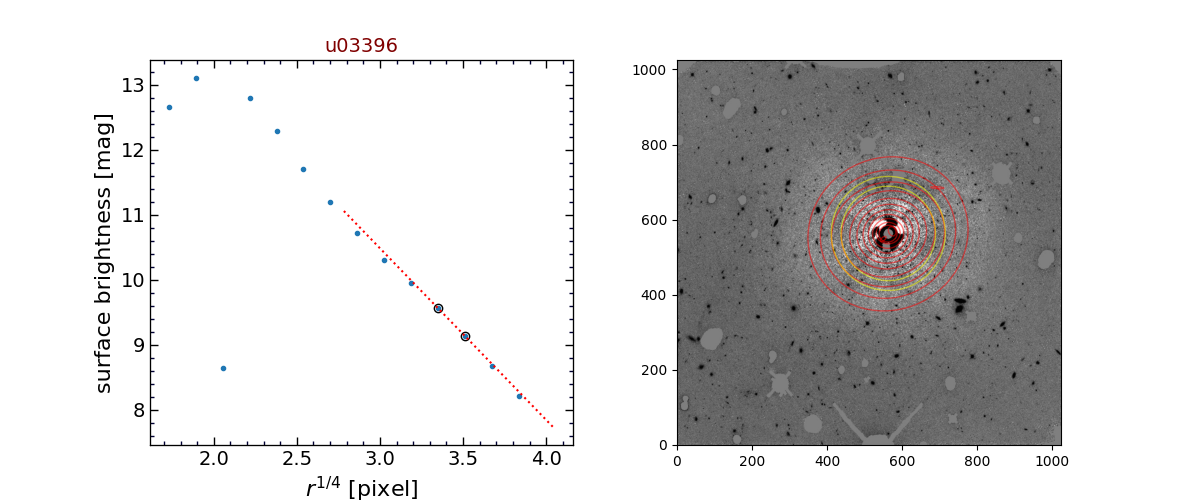

No. of crossing ellipses: 2
fig. name:  Outputs_u03396//u03396_light_profile.png


In [15]:
sky = int(sky_factor*obj.sky_med)

# using final mask = 1 --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med*sky_factor, niter=10, mask=1, model_mask=0, options=options)

model = 0
root = obj.objRoot
suffix = '.%03d'%model

ellipseFile = root+'/elliprof'+suffix
df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
df = df.apply(pd.to_numeric, errors='coerce')

# fig, ax = plt.subplots(1,1, figsize=(7,6))
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,5))

x = df.Rmaj**0.25
y = 2.5*np.log10(df.I0)
ax.plot(x, y, '.')

ax.set_xlabel(r"$r^{1/4}$"+" [pixel]", fontsize=16)
ax.set_ylabel(r"surface brightness"+" [mag]", fontsize=16)

maxX = np.max(x)
minX = np.min(x)
dx = maxX-minX
x1 = 0.70*dx+minX
x2 = maxX-0.10*dx
x0 = x[((x<x2) & (x>x1))]
y0 = y[((x<x2) & (x>x1))]
ax.plot(x0, y0, 'ko', mfc='none')

m, b = np.polyfit(x0, y0, 1)

xrange = np.linspace(x1-0.2*dx, maxX+0.1*dx, 100)
yrange = m*xrange+b

ax.plot(xrange, yrange, 'r:')
set_axes(ax, fontsize=14)

ax.set_title(obj.name, fontsize=14, color='maroon')
##################################################
obj.tv_resid(model=0, options='sqrt', ax=ax2)
obj.plot_ellipse(model=0, ax=ax2, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')
n_cross = Xellipses(obj.list_ellipses(model=0))
print("No. of crossing ellipses: %d"%n_cross)


## center, Smajor, Smainor, angle
Ell = make_Ellipse((obj.x0, obj.y0), min(x0)**4, min(x0)**4, 0)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='yellow', facecolor='none')
ax2.add_patch(e)

Ell = make_Ellipse((obj.x0, obj.y0), max(x0)**4, max(x0)**4, 0)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='yellow', facecolor='none')
ax2.add_patch(e)


pngName = obj.objRoot+'/'+obj.name+'_light_profile.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

In [18]:
df.head()

,Rmaj,x0,y0,I0,alpha,ellip,I(3x),A(3x),I(4x),A(4x),slope
0,9.0,548.91,549.97,157083.2,37.13,0.894,0.0061,47.98,0.0074,4.15,-1.31
1,12.9,568.88,568.49,68572.9,104.28,0.895,0.2698,64.21,0.0052,22.14,-0.10
2,17.8,556.74,549.69,152354.4,69.90,0.693,0.2246,85.60,0.1027,41.10,-2.00
3,24.2,562.83,562.57,131944.1,112.19,0.073,0.0038,7.37,0.0031,34.26,-0.92
4,32.0,563.14,563.53,81271.1,92.85,0.083,0.0489,8.68,0.0391,24.99,-1.89


In [19]:
sky_factor

0.96

In [20]:
sky

2269

## Visualizing the background histogram

In the following cell, the distribution of the residual values of the background pixels is plotted.
In the case of having a good model and sky value, the median/mean values of the residuals should be close to zero.

**Note:** Sometimes, very bright objects must be masked out manually to makes sure that there no contamination from such objects, otherwise the background must have been over-estimated.

Back Median: 118.23
Back Mean: 118.93
Back Stdev: 77.81


<IPython.core.display.Javascript object>


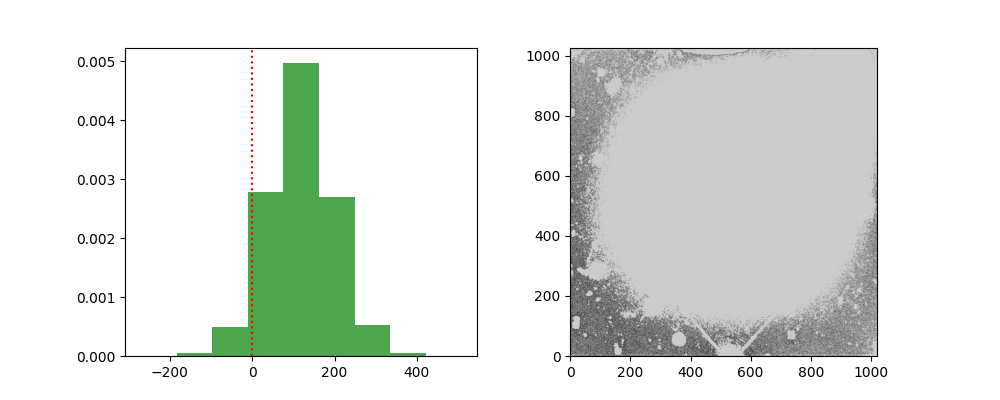

fig. name:  Outputs_u03396//u03396_updated_back.png


0.9500180158078984

In [17]:
resid_name = obj.objRoot+"resid.000"
back_mask = obj.objRoot+"back_mask.fits"

imarray, header = imOpen(resid_name)
mskarray, header = imOpen(back_mask)

masked_image = imarray*mskarray

fits.writeto('./tmp.fits', np.float32(masked_image), overwrite=True)

## plot_2darray(imarray)
# tv('./tmp.fits', options='log')


a = masked_image
a = a[(a!=0)]
std = np.std(a)
mean = np.mean(a)

a = a[((a>mean-3.*std)&(a<mean+3.*std))]

median = np.median(a)
mean = np.mean(a)
std = np.std(a)

print("Back Median: %.2f"%median)
print("Back Mean: %.2f"%mean)
print("Back Stdev: %.2f"%std)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.hist(a, bins=np.linspace(mean-5*std, mean+5*std, 10), density=True, color='g', alpha=0.7)
tv('./tmp.fits', ax=ax2, options="")

ax1.axvline(x=0, color='r', linestyle=':')

new_factor = median/obj.sky_med + sky_factor


pngName = obj.objRoot+'/'+obj.name+'_updated_back.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

new_factor

## Saving the model

Here, we store all metadata and other information on disk to be used in other steps.

In [18]:
import os, uuid
from datetime import datetime

now = datetime.now()
model_uuid = str(uuid.uuid1())

objDict = {}

objDict["index"] = 'value'
objDict["uuid"] = model_uuid
objDict["User"] = os.getlogin().capitalize()
objDict["Time"] = now
objDict["Name"] = obj.name
objDict["X_pixels"] = obj.x_max
objDict["Y_pixels"] = obj.y_max
objDict["R_max"] = obj.r_max
objDict["X0"] = obj.x0
objDict["Y0"] = obj.y0
objDict["a"] = "%.3f"%obj.a
objDict["b"] = "%.3f"%obj.b
objDict["sky_med"] = "%.3f"%median
objDict["sky_avg"] = "%.3f"%mean
objDict["sky_std"] = "%.3f"%std
objDict["r0"] = r0
objDict["r1"] = r1
objDict["nr"] = nr
objDict["k"] = k
objDict["c_kron"] = c_kron
objDict["options"] = options
objDict["sky_factor"] = "%.2f"%sky_factor
objDict["sky"] = sky
objDict["initial_sky_med"] = "%.3f"%obj.sky_med
objDict["initial_sky_avg"] = "%.3f"%obj.sky_ave
objDict["initial_sky_std"] = "%.3f"%obj.sky_std

objDict["obj_root"] = obj.objRoot

objDict["resid_name"] = obj.objRoot+"resid.000"
objDict["model_name"] = obj.objRoot+"model.000"
objDict["back_mask"] = obj.objRoot+"back_mask.fits"
objDict["ellipseFile"] = root+'elliprof'+suffix

#######################################################################

df = pd.DataFrame.from_dict(objDict, orient='index', columns=['value'])
df['description'] = ''

#######################################################################
df.at["index", "description"] =  'description'
df.at["uuid", "description"] =  'Unique Identifier Code'
df.at["Name", "description"] =  'Object Name'
df.at["User", "description"] =  'User Name'
df.at["Time", "description"] =  'Modification Time'
df.at["X_pixels", "description"] =  'X-dimension of image [pixel]'
df.at["Y_pixels", "description"] =  'Y-dimension of image [pixel]'
df.at["R_max", "description"] =  'maximum horizontal/vertical distance from center to the image border [pixel]'
df.at["X0", "description"] =  'Object Center X0 [pixel]'
df.at["Y0", "description"] =  'Object Center Y0 [pixel]'
df.at["a", "description"] =  'semi-major axis [pixel]'
df.at["b", "description"] =  'semi-minor axis [pixel]'
df.at["sky_med", "description"] =  'median sky background after model subtraction'
df.at["sky_avg", "description"] =  'mean sky background after model subtraction'
df.at["sky_std", "description"] =  '1-sigma standard deviation of the sky background after model subtraction'
df.at["r0", "description"] =  'elliprof: inner fit radius'
df.at["r1", "description"] =  'elliprof: outer fit radius'
df.at["nr", "description"] =  'elliprof: number of fitted radii '
df.at["k", "description"] =  'nr=[r1/k]'
df.at["c_kron", "description"] =  'Kron radius factor'
df.at["options", "description"] =  'elliprof: options'
df.at["sky_factor", "description"] =  'sky factor'
df.at["sky", "description"] =  'sky level = sky_factor*initial_sky_median'
df.at["initial_sky_med", "description"] =  'initial sky median'
df.at["initial_sky_avg", "description"] =  'initial sky mean'
df.at["initial_sky_std", "description"] =  'initial sky standard deviation'

df.at["obj_root", "description"] =  'name of the outputs folder'

df.at["resid_name", "description"] =  'residual image [fits]'
df.at["model_name", "description"] =   'model image [fits]'
df.at["back_mask", "description"] =   'background mask [fits]'
df.at["ellipseFile", "description"] =   'ellipse file [text]'

#######################################################################

df = df.reset_index()
logFile = obj.objRoot+obj.name+"_model_log.csv"

from os.path import exists

if not exists(logFile):
    xcmd("echo '###### uuid:'"+model_uuid+"  > "+logFile+".temp", verbose=False)  # header
    np.savetxt(logFile, df.values, fmt='%20s , %40s , %80s')
    xcmd("cat "+logFile+" >> "+logFile+".temp", verbose=False)
    xcmd("mv "+logFile+".temp "+logFile, verbose=False)
else:   
    xcmd("echo '###### uuid:'"+model_uuid+"  > "+logFile+".temp~", verbose=False)  # header
    
    np.savetxt(logFile+".temp", df.values, fmt='%20s , %40s , %80s')
    xcmd("echo   >> "+logFile+".temp", verbose=False)
    
    xcmd("cat "+logFile+".temp"+" >> "+logFile+".temp~", verbose=False)
    xcmd("cat "+logFile+" >> "+logFile+".temp~", verbose=False)
    
    xcmd("mv "+logFile+".temp~ "+logFile, verbose=False)
    xcmd("rm "+logFile+".temp", verbose=False)
    
print("Log File: ", logFile)

df

Log File:  Outputs_u03396/u03396_model_log.csv


,index,value,description
0,index,value,description
1,uuid,79d35652-e36f-11ec-a986-c5818d0dc683,Unique Identifier Code
2,User,Ehsan,User Name
3,Time,2022-06-03 12:00:46.640995,Modification Time
4,Name,u03396,Object Name
5,X_pixels,1022,X-dimension of image [pixel]
6,Y_pixels,1025,Y-dimension of image [pixel]
7,R_max,458,maximum horizontal/vertical distance from cent...
8,X0,563.268,Object Center X0 [pixel]
9,Y0,563.234,Object Center Y0 [pixel]
